## COVID-19 and North Carolina Communities
### Lukas Brun, Colby Hoke, Alexander “Chess” Rosati, Connor Reside
#### UNC Data Analytics Bootcamp
#### July 23, 2020

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import covid_api
from config import google_api
import gmaps
import glob
import os
from scipy.stats import linregress
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy


# Census risk data (experimental):

In [2]:
# --------------------------------------------------------------------------------------------
# Get risk factor data for North Carolina, based on census data
# Import CRE csv from
# https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/
# --------------------------------------------------------------------------------------------


risk_path = "https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/cre-2018-a11.csv"

# If the above breaks, use the downloaded CSV
#risk_path = "data/cre-2018-a11.csv"
risk_df = pd.read_csv(risk_path)

# Break down by North Carolina
nc_risk_df = risk_df.loc[risk_df['STABREV']=='NC']

# Display dataframe
nc_risk_df


,state,county,tract,rfgrp,prednum,prednum_moe,predrt,predrt_moe,stname,STABREV,ctname,popuni
150009,37,1,0,0RF,48284,9880.2,29.84,6.11,North Carolina,NC,"Alamance County, NC",161790
150010,37,1,0,1-2RF,74707,10852.5,46.18,6.71,North Carolina,NC,"Alamance County, NC",161790
150011,37,1,0,3PLRF,38799,9176.3,23.98,5.67,North Carolina,NC,"Alamance County, NC",161790
150012,37,1,20100,0RF,1122,385.8,26.26,9.03,North Carolina,NC,"Alamance County, NC",4272
150013,37,1,20100,1-2RF,2003,410.3,46.89,9.60,North Carolina,NC,"Alamance County, NC",4272
...,...,...,...,...,...,...,...,...,...,...,...,...
156889,37,199,960300,1-2RF,1289,301.9,42.19,9.88,North Carolina,NC,"Yancey County, NC",3055
156890,37,199,960300,3PLRF,827,283.9,27.07,9.29,North Carolina,NC,"Yancey County, NC",3055
156891,37,199,960400,0RF,1135,358.4,26.43,8.34,North Carolina,NC,"Yancey County, NC",4295
156892,37,199,960400,1-2RF,1998,401.6,46.52,9.35,North Carolina,NC,"Yancey County, NC",4295


In [3]:
# -----------------
# Clean up the data
# -----------------
nc_risk_df = nc_risk_df[['tract','rfgrp','prednum','ctname','popuni']]
nc_risk_rename_df = nc_risk_df.rename(columns={
    'rfgrp':'risk_group',
    'prednum':'risk_pop',
    'ctname':'county',
    'popuni':'total_pop'})

# Clean up the county name column
nc_risk_rename_df['county'].replace(' County, NC','',regex=True,inplace=True)

# We only need to keep the data where tract = 0, as that's the county summaries
nc_risk_grouped = nc_risk_rename_df.groupby(['county','tract','risk_group']).sum()
nc_risk_grouped.reset_index(inplace=True)
nc_risk_filtered = nc_risk_grouped[nc_risk_grouped['tract'] == 0] 

# Reorder the dataframe
nc_risk_filtered = nc_risk_filtered[['county','risk_group','risk_pop','total_pop']]

# Display the dataframe
nc_risk_filtered

,county,risk_group,risk_pop,total_pop
0,Alamance,0RF,48284,161790
1,Alamance,1-2RF,74707,161790
2,Alamance,3PLRF,38799,161790
111,Alexander,0RF,9789,36096
112,Alexander,1-2RF,17442,36096
...,...,...,...,...
6844,Yadkin,1-2RF,16689,37498
6845,Yadkin,3PLRF,10706,37498
6867,Yancey,0RF,4307,17870
6868,Yancey,1-2RF,8271,17870


In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Report statewide North Carolina risk factor groups
#     0RF = no risk factors
#     1-2RF = 1-2 risk factors
#     3PLRF = 3+ risk factors
# Explanation of risk factors:
# https://www2.census.gov/data/experimental-data-products/community-resilience-estimates/2020/technical-document.pdf?#
# --------------------------------------------------------------------------------------------------------------------

# Make a new dataframe from the other
nc_overall_risk_df = nc_risk_filtered

# Group by risk factors
nc_overall_risk = nc_overall_risk_df.groupby('risk_group').sum()

# Build new series to hold percentages
nc_overall_risk['percentage'] = ''

# Iterate over rows to calculate percentages, round, and store in the new series 
for index, row in nc_overall_risk.iterrows():
    nc_overall_risk.at[index,'percentage'] = round((row['risk_pop'] / row['total_pop'])*100,2)

# Display the dataframe
nc_overall_risk

,risk_pop,total_pop,percentage
risk_group,,,
0RF,2896542,10219101,28.34
1-2RF,4866961,10219101,47.63
3PLRF,2455598,10219101,24.03


In [5]:
# ------------------------------------------------------------------------------
# Report risk factor groups, by county, for North Carolina, based on census data
# ------------------------------------------------------------------------------

nc_county_risk = nc_risk_filtered

# Build new series to hold percentages
nc_county_risk['percentage'] = ''

# Iterate over rows to calculate percentages, round, and store in the new series 
for index, row in nc_county_risk.iterrows():
    nc_county_risk.at[index,'percentage'] = round((row['risk_pop'] / row['total_pop'])*100,2)

# Display the dataframe
nc_county_risk


,county,risk_group,risk_pop,total_pop,percentage
0,Alamance,0RF,48284,161790,29.84
1,Alamance,1-2RF,74707,161790,46.18
2,Alamance,3PLRF,38799,161790,23.98
111,Alexander,0RF,9789,36096,27.12
112,Alexander,1-2RF,17442,36096,48.32
...,...,...,...,...,...
6844,Yadkin,1-2RF,16689,37498,44.51
6845,Yadkin,3PLRF,10706,37498,28.55
6867,Yancey,0RF,4307,17870,24.1
6868,Yancey,1-2RF,8271,17870,46.28


# NYTimes data:

In [6]:
# -----------------------
# This is a NYTimes report on national COVID-19 cases and deaths, sorted by county
# From: https://github.com/nytimes/covid-19-data (us-counties.csv)
# -----------------------

# Pull in the live data
counties_path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
# If the above breaks, we can refer to the saved version of the csv, below:
#counties_path = "data/us-counties.csv"

# Save to a dataframe
covid_df = pd.read_csv(counties_path)

# Sort for NC
covid_county_df = covid_df.loc[covid_df['state']=='North Carolina']

# Drop irrelevant column(s)
covid_county_clean_df = covid_county_df.drop(['fips'], 1)

# Grab last 100 rows (for 100 counties to get latest data)
covid_county_latest_df = covid_county_clean_df.tail(100)

# Diplay the dataframe
covid_county_latest_df

,date,county,state,cases,deaths
358646,2020-07-22,Alamance,North Carolina,1809,40
358647,2020-07-22,Alexander,North Carolina,225,2
358648,2020-07-22,Alleghany,North Carolina,53,0
358649,2020-07-22,Anson,North Carolina,267,1
358650,2020-07-22,Ashe,North Carolina,75,1
...,...,...,...,...,...
358741,2020-07-22,Wayne,North Carolina,2142,35
358742,2020-07-22,Wilkes,North Carolina,672,7
358743,2020-07-22,Wilson,North Carolina,1200,28
358744,2020-07-22,Yadkin,North Carolina,419,6


In [7]:
# -----------------------
# Build a dataframe that shows worst 10 counties in cases and deaths
# -----------------------

# Sort by cases, highest to lowest
sorted_cases = covid_county_latest_df.sort_values(by=['cases'],ascending=False).reset_index()
# Sort by deaths, highest to lowest
sorted_deaths = covid_county_latest_df.sort_values(by=['deaths'],ascending=False).reset_index()

# Build a new dataframe to hold top counties and the value, sorted by cases and deaths
top_df = pd.DataFrame(columns=['Most cases','Case count','Most deaths','Death count'])

# Add the cases to the new dataframe
top_df['Most cases'] = sorted_cases['county'].values
top_df['Case count'] = sorted_cases['cases'].values

# Add the deaths to the new dataframe
top_df['Most deaths'] = sorted_deaths['county'].values
top_df['Death count'] = sorted_deaths['deaths'].values

# Show the top 10 counties for cases and deaths
top_df.head(10)

,Most cases,Case count,Most deaths,Death count
0,Mecklenburg,18075,Mecklenburg,186
1,Wake,9313,Guilford,135
2,Durham,5269,Wake,99
3,Guilford,4412,Durham,74
4,Forsyth,4343,Henderson,52
5,Johnston,2490,Buncombe,51
6,Gaston,2432,Robeson,49
7,Union,2287,Chatham,47
8,Wayne,2142,Rowan,47
9,Cumberland,2101,Cumberland,47


In [8]:
# -----------------------
# Combine dataframes from NYTimes data and CRE data
# NYT = covid_county_latest_df
# CRE = nc_county_risk
# -----------------------

# Do the merge
combined_data = pd.merge(nc_county_risk, covid_county_latest_df, on='county', how='outer')

# Display the dataframe
combined_data


,county,risk_group,risk_pop,total_pop,percentage,date,state,cases,deaths
0,Alamance,0RF,48284,161790,29.84,2020-07-22,North Carolina,1809,40
1,Alamance,1-2RF,74707,161790,46.18,2020-07-22,North Carolina,1809,40
2,Alamance,3PLRF,38799,161790,23.98,2020-07-22,North Carolina,1809,40
3,Alexander,0RF,9789,36096,27.12,2020-07-22,North Carolina,225,2
4,Alexander,1-2RF,17442,36096,48.32,2020-07-22,North Carolina,225,2
...,...,...,...,...,...,...,...,...,...
295,Yadkin,1-2RF,16689,37498,44.51,2020-07-22,North Carolina,419,6
296,Yadkin,3PLRF,10706,37498,28.55,2020-07-22,North Carolina,419,6
297,Yancey,0RF,4307,17870,24.1,2020-07-22,North Carolina,68,0
298,Yancey,1-2RF,8271,17870,46.28,2020-07-22,North Carolina,68,0


In [9]:
# -------------------------------------------------------------
# Build dataframe to show:
#     Cases and deaths as a percentage of the county population
#     Deaths as a percentage of cases
# -------------------------------------------------------------

# Build empty dataframe and order columns
summary_df = pd.DataFrame(columns={
    'county',
    'cases_pop_pct',
    'deaths_cases_pct',
    'deaths_pop_pct',
    'cases',
    'deaths',
    'population'})

# Order columns
summary_df = summary_df[[
    'county','cases','deaths','population','cases_pop_pct','deaths_pop_pct','deaths_cases_pct']]

# Set empty lists to store values
county_lst = []
cases_lst = []
deaths_lst = []
pop_lst = []

# This variable checks to see if we've seen this county already
county = ''

#Iterate through the data and build lists to go into the new summary dataframe
for i, row in combined_data.iterrows():
    if county == row[0]: # This handles 2nd and 3rd occurrance of county
        pass
    else: # This handles first occurrance of county
        county_lst.append(row[0])
        cases_lst.append(row[7])
        deaths_lst.append(row[8])
        pop_lst.append(row[3])
        
        county = row[0]

# Build the summary dataframe
summary_df['county'] = county_lst
summary_df['cases'] = cases_lst
summary_df['deaths'] = deaths_lst
summary_df['population'] = pop_lst

# Do calculations for percentages
for i, row in summary_df.iterrows():
    summary_df.loc[i,'cases_pop_pct']= f'{round(((row[1]/row[3])*100),4)}%'
    summary_df.loc[i,'deaths_pop_pct']= f'{round(((row[2]/row[3])*100),4)}%'
    summary_df.loc[i,'deaths_cases_pct']= f'{round(((row[2]/row[1])*100),4)}%'

# Display the summary dataframe   
summary_df

,county,cases,deaths,population,cases_pop_pct,deaths_pop_pct,deaths_cases_pct
0,Alamance,1809,40,161790,1.1181%,0.0247%,2.2112%
1,Alexander,225,2,36096,0.6233%,0.0055%,0.8889%
2,Alleghany,53,0,11146,0.4755%,0.0%,0.0%
3,Anson,267,1,22949,1.1634%,0.0044%,0.3745%
4,Ashe,75,1,27068,0.2771%,0.0037%,1.3333%
...,...,...,...,...,...,...,...
95,Wayne,2142,35,122647,1.7465%,0.0285%,1.634%
96,Wilkes,672,7,68118,0.9865%,0.0103%,1.0417%
97,Wilson,1200,28,80922,1.4829%,0.0346%,2.3333%
98,Yadkin,419,6,37498,1.1174%,0.016%,1.432%


# Census demographic data:

In [10]:
# --------------------------------------------------------------
# Combine NC County Demographic CSVs
# From https://www.census.gov/quickfacts/fact/table/US/PST045219
# --------------------------------------------------------------

# Find all csv files using glob pattern matching with extension = 'csv'
# by saving results in a list titled all_county
os.chdir('./nc_county_demographics')
extension = 'csv'
all_county = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
nc_demographic = pd.concat([pd.read_csv(f) for f in all_county ])
nc_demographic = nc_demographic.dropna().rename(columns={'Fact': 'county'})

# Create New Dataframe to retrieve the demographic data per county
# Set Columns for new Dataframe
demo_summary = pd.DataFrame(columns=['County','% Female','% White','% Black','% Hispanic','% Population Under 18'
                                     '% Graduated Highschool','% College Graduate','People Per Household',
                                     'Median Household Income','Poverty Rate','% Without Health Insurance (<65)'])

# Set values for new demographic dataframe
demo_summary['County'] = nc_demographic['county'].values
demo_summary['Female (%)'] = nc_demographic['Female persons, percent'].values
demo_summary['White (%)'] = nc_demographic['White alone, not Hispanic or Latino, percent'].values
demo_summary['Black (%)'] = nc_demographic['Black or African American alone, percent'].values
demo_summary['Hispanic (%)'] = nc_demographic['Hispanic or Latino, percent'].values
demo_summary['Population Under 18 (%)'] = nc_demographic['Persons under 18 years, percent'].values
demo_summary['Population 65 and Over (%)'] = nc_demographic['Persons 65 years and over, percent'].values
demo_summary['Graduated Highschool (%)'] = nc_demographic['High school graduate or higher, percent of persons age 25 years+, 2014-2018'].values
demo_summary['College Graduate (%)'] = nc_demographic['Bachelors degree or higher, percent of persons age 25 years+, 2014-2018'].values
demo_summary['Median Household Income'] = nc_demographic['Median household income (in 2018 dollars), 2014-2018'].values
demo_summary['Poverty Rate'] = nc_demographic['Persons in poverty, percent'].values
demo_summary['% Without Health Insurance (<65)'] = nc_demographic['Persons  without health insurance, under age 65 years, percent'].values
demo_summary['Land area'] = nc_demographic['Land area in square miles, 2010'].values

# Format new demographic data
demo_summary1 = demo_summary.transpose().dropna()
demo_summary2 = demo_summary1.transpose()
demo_summary2.sort_values('County', axis = 0, ascending = True, inplace = True)
demo_summary3 = demo_summary2.reset_index(drop = True)

# Add data from summary_df
demo_summary3['Population'] = summary_df['population'].values
demo_summary3['Cases'] = summary_df['cases'].values
demo_summary3['Deaths'] = summary_df['deaths'].values
demo_summary3['Cases/Population (%)'] = summary_df['cases_pop_pct'].values
demo_summary3['Cases Per 10,000 Residents'] = ((summary_df['cases'] / summary_df['population']) * 10000).values
demo_summary3['Deaths/Population (%)'] = summary_df['deaths_pop_pct'].values
demo_summary3['Deaths/Cases (%)'] = summary_df['deaths_cases_pct'].values
demo_summary3['Pop Density per mile'] =  demo_summary3['Population'] / demo_summary3['Land area']

# Reorder columns to look nice
demo_summary4 = demo_summary3[['County','Population','Female (%)','White (%)','Black (%)',
                               'Hispanic (%)','Population Under 18 (%)','Population 65 and Over (%)',
                               'Graduated Highschool (%)','College Graduate (%)','Median Household Income',
                               'Poverty Rate','% Without Health Insurance (<65)','Cases','Cases Per 10,000 Residents',
                               'Deaths','Cases/Population (%)','Deaths/Population (%)','Deaths/Cases (%)','Land area','Pop Density per mile']]

# Change the directory back
os.chdir('..')

# Display the dataframe
demo_summary4


,County,Population,Female (%),White (%),Black (%),Hispanic (%),Population Under 18 (%),Population 65 and Over (%),Graduated Highschool (%),College Graduate (%),...,Poverty Rate,% Without Health Insurance (<65),Cases,"Cases Per 10,000 Residents",Deaths,Cases/Population (%),Deaths/Population (%),Deaths/Cases (%),Land area,Pop Density per mile
0,Alamance,161790,52.50%,62.90%,20.90%,13.10%,22.00%,17.10%,85.50%,24.00%,...,13.50%,13.80%,1809,111.811608,40,1.1181%,0.0247%,2.2112%,423.94,381.634
1,Alexander,36096,49.00%,86.70%,5.90%,4.80%,19.90%,20.40%,81.60%,14.70%,...,13.00%,12.80%,225,62.333777,2,0.6233%,0.0055%,0.8889%,259.99,138.836
2,Alleghany,11146,50.40%,86.70%,1.80%,9.90%,17.00%,28.00%,76.60%,16.70%,...,18.70%,17.80%,53,47.550691,0,0.4755%,0.0%,0.0%,235.06,47.4177
3,Anson,22949,48.70%,44.30%,48.50%,4.10%,19.80%,19.30%,80.50%,9.60%,...,20.50%,13.40%,267,116.344939,1,1.1634%,0.0044%,0.3745%,531.45,43.1819
4,Ashe,27068,51.00%,92.30%,1.00%,5.10%,17.40%,26.60%,84.20%,19.00%,...,16.90%,15.40%,75,27.707995,1,0.2771%,0.0037%,1.3333%,426.14,63.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wayne,122647,51.30%,52.70%,32.40%,12.40%,23.60%,16.90%,84.10%,19.50%,...,20.20%,14.80%,2142,174.647566,35,1.7465%,0.0285%,1.634%,553.09,221.749
96,Wilkes,68118,50.90%,86.70%,4.70%,6.90%,20.10%,22.20%,78.60%,15.50%,...,18.90%,15.30%,672,98.652339,7,0.9865%,0.0103%,1.0417%,754.28,90.3086
97,Wilson,80922,52.60%,46.80%,40.50%,10.80%,22.70%,18.70%,80.30%,19.60%,...,21.10%,14.70%,1200,148.290947,28,1.4829%,0.0346%,2.3333%,368.17,219.795
98,Yadkin,37498,50.50%,83.80%,3.40%,11.50%,20.80%,20.50%,81.00%,11.30%,...,13.00%,14.50%,419,111.739293,6,1.1174%,0.016%,1.432%,334.83,111.991


# Combine data:

In [11]:
# ------------------------------------------
# Reuse the nc_county_risk dataframe and
# break out communities by zero risk factors
# ------------------------------------------

risk_df = nc_county_risk

# Remove rows with >0 risk factors
risk_df = risk_df[~risk_df.risk_group.str.contains("1-2")]
risk_df = risk_df[~risk_df.risk_group.str.contains("PL")]

# Cast the 0RF percentage to a list
risk_list = risk_df['percentage'].tolist()

# Cast the whole dataframe to a string to remove extraneous characters
df = demo_summary4.astype(str)

for x in df:
    if x == 'County':
        continue
    if x == 'Cases Per 10,000 Residents':
        df[x] = df[x].astype('float')
        continue 
    if x == 'Pop Density per mile':
        df[x] = df[x].astype('float')
        continue  
    if(df[x].dtype == 'object'):
        if df[x].str.contains('%').any():
            df[x] = df[x].str.replace(',', '')
            df[x] = df[x].str.replace('%', '')
            df[x] = df[x].astype('float')
            continue
        df[x] = df[x].str.replace('$', '')
        df[x] = df[x].str.replace('.', '')
        df[x] = df[x].str.replace(',', '')
        df[x] = df[x].astype('float')
               
# Pull in the 0RF data
df['0 Risk Factor Pop (%)'] = risk_list

# Display the dataframe
df

,County,Population,Female (%),White (%),Black (%),Hispanic (%),Population Under 18 (%),Population 65 and Over (%),Graduated Highschool (%),College Graduate (%),...,% Without Health Insurance (<65),Cases,"Cases Per 10,000 Residents",Deaths,Cases/Population (%),Deaths/Population (%),Deaths/Cases (%),Land area,Pop Density per mile,0 Risk Factor Pop (%)
0,Alamance,161790.0,52.5,62.9,20.9,13.1,22.0,17.1,85.5,24.0,...,13.8,1809.0,111.811608,40.0,1.1181,0.0247,2.2112,42394.0,381.634194,29.84
1,Alexander,36096.0,49.0,86.7,5.9,4.8,19.9,20.4,81.6,14.7,...,12.8,225.0,62.333777,2.0,0.6233,0.0055,0.8889,25999.0,138.836109,27.12
2,Alleghany,11146.0,50.4,86.7,1.8,9.9,17.0,28.0,76.6,16.7,...,17.8,53.0,47.550691,0.0,0.4755,0.0000,0.0000,23506.0,47.417681,24.53
3,Anson,22949.0,48.7,44.3,48.5,4.1,19.8,19.3,80.5,9.6,...,13.4,267.0,116.344939,1.0,1.1634,0.0044,0.3745,53145.0,43.181861,22.98
4,Ashe,27068.0,51.0,92.3,1.0,5.1,17.4,26.6,84.2,19.0,...,15.4,75.0,27.707995,1.0,0.2771,0.0037,1.3333,42614.0,63.519031,25.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wayne,122647.0,51.3,52.7,32.4,12.4,23.6,16.9,84.1,19.5,...,14.8,2142.0,174.647566,35.0,1.7465,0.0285,1.6340,55309.0,221.748721,24.38
96,Wilkes,68118.0,50.9,86.7,4.7,6.9,20.1,22.2,78.6,15.5,...,15.3,672.0,98.652339,7.0,0.9865,0.0103,1.0417,75428.0,90.308639,25.16
97,Wilson,80922.0,52.6,46.8,40.5,10.8,22.7,18.7,80.3,19.6,...,14.7,1200.0,148.290947,28.0,1.4829,0.0346,2.3333,36817.0,219.795203,24.86
98,Yadkin,37498.0,50.5,83.8,3.4,11.5,20.8,20.5,81.0,11.3,...,14.5,419.0,111.739293,6.0,1.1174,0.0160,1.4320,33483.0,111.991160,26.94


# Initial observations:
### As population increases, cases per 10000 residents also seems to increase.
#### Counties with lower non-white populations seem to have lower rates of COVID.
#### Difficult to say at a glance whether or not education and median income have significant impacts.

# Results:


In [12]:
# ------------------------------------------------------------------
# Build a function to calculate and print out all regressions
# Input:
#     x_val = X value to plot
#     y_val = Y value to plot
#     anno_x = Control over annotation line X value
#     anno_y = Control over annotation line Y value
#     fig = Figure number. These are set 1-12 to keep track of order
# ------------------------------------------------------------------


def regress_function(x_val,y_val,anno_x,anno_y,fig):
    x_values = df[x_val]
    y_values = df[y_val]
    # Build regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    # Build the plot
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")

    # Label the plot
    plt.annotate(line_eq,(anno_x,anno_y),fontsize=15,color="red")
    plt.xlabel(x_val)
    plt.ylabel(y_val)
    plt.title(f'{x_val} vs. {y_val}')

    # Export and display the plot
    #plt.savefig(r'output_data/Fig01-Cases_Per_10,000_vs_Population_at_0_Risk_Factor.png')
    
    substring = '%'
    
    if substring in x_val:
            x_name = x_val.replace('%', 'Pct')    
    else:
        x_name = x_val
    
    if substring in y_val:
            y_name = y_val.replace('%', 'Pct')    
    else:
        y_name = y_val

    plt.savefig(f'output_data/Fig{fig}-{x_name} vs. {y_name}.png')
    plt.show()
    print(f"The r-squared is: {rvalue**2}")
    
    return

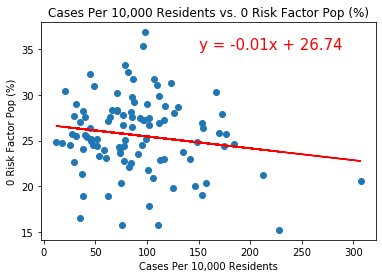

The r-squared is: 0.02487261539874131


In [13]:
regress_function('Cases Per 10,000 Residents','0 Risk Factor Pop (%)',150,35,1)

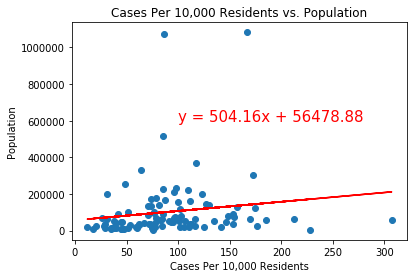

The r-squared is: 0.02350716773188299


In [14]:
regress_function('Cases Per 10,000 Residents','Population',100,600000,2)

### NOTES:
#### Population seems to have very little effect on proportional cases, let's see if this changes if we drop the most significant outlier, Duplin county.

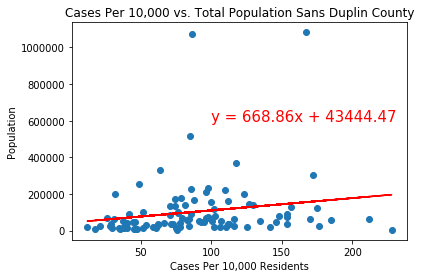

The r-squared is: 0.033558362024486324


In [15]:


# Remove Duplin County
df2 = df.drop(df.index[30])

# Build x and y values
x_values = df2['Cases Per 10,000 Residents']
y_values = df2['Population']

# Build regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Build the plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label the plot
plt.annotate(line_eq,(100,600000),fontsize=15,color="red")
plt.xlabel('Cases Per 10,000 Residents')
plt.ylabel('Population')
plt.title('Cases Per 10,000 vs. Total Population Sans Duplin County')

# Export and display the plot
plt.savefig(r'output_data/Fig3-Cases_Per_10,000_vs_Population_sans_Duplin.png')
plt.show()
print(f"The r-squared is: {rvalue**2}")

### NOTES:
#### Better, but population still explains less than 5% of the variance.
#### Let's examinme the percentage of children in the population. 
#### There have been claims the the virus is spread most prominently by children, however given the small variation in percentage of children in each county I would not expect this to be a significant explanatory factor.

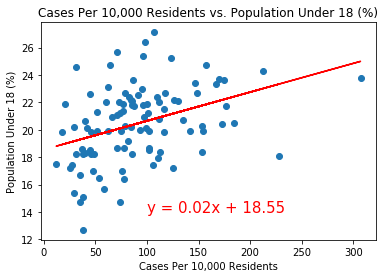

The r-squared is: 0.14456658578569206


In [16]:
regress_function('Cases Per 10,000 Residents','Population Under 18 (%)',100,14,4)

### NOTES:
#### Quite good considering the number of variables involved, and it does seem that children do indeed spread the virus more.
#### Let's examine the percentage of senior citizens.

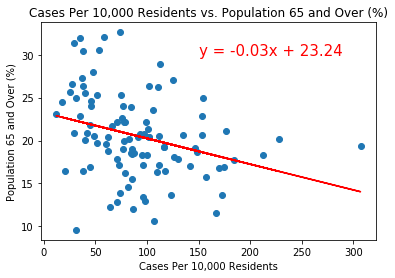

The r-squared is: 0.0931730492030104


In [17]:
regress_function('Cases Per 10,000 Residents','Population 65 and Over (%)',150,30,5)

### NOTES:
#### Significantly less of a factor than children, and higher percentages of elderly people have less instances of the virus.
#### Potentially a result of less children in these communities.
#### Let's take a look at gender, which is unlikely to have a significant impact.

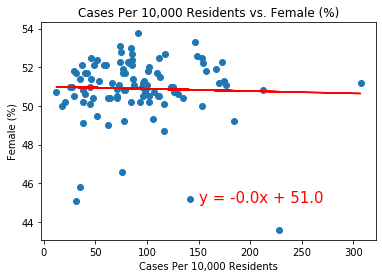

The r-squared is: 0.0012625664857591704


In [18]:
regress_function('Cases Per 10,000 Residents','Female (%)',150,45,6)

### NOTES:
#### Unsurpisingly not much to see there.
#### Let's examine the percentage of white people in the county.
#### Since the virus has disproportionately affected minorities, we would expect a negative correlation between the percentage of white people and the proportional cases.

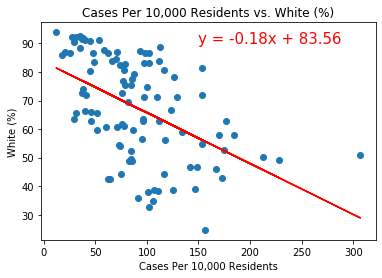

The r-squared is: 0.2517063107962462


In [19]:
regress_function('Cases Per 10,000 Residents','White (%)',150,90,7)

### NOTES:
#### Indeed there is a fairly significant negative correlation there.
#### Let's examine median income. Low income familes are likely to have less access to health care and live in more crowded conditions, so we would imagine some negative correlation here.

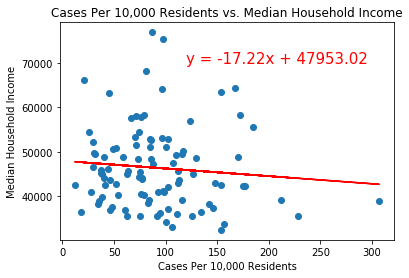

The r-squared is: 0.00885959923091779


In [20]:
regress_function('Cases Per 10,000 Residents','Median Household Income',120,70000,8)

### NOTES:
#### Almost no correlation at all. Let's take a look at poverty rate instead.

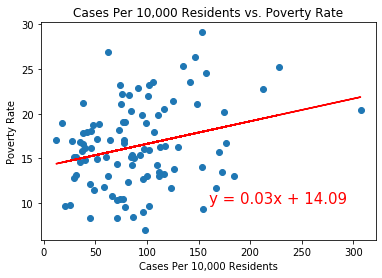

The r-squared is: 0.07292773913029853


In [21]:
regress_function('Cases Per 10,000 Residents','Poverty Rate',160,10,9)

### NOTES:
#### Better, but still a small correlation. Let's try education.

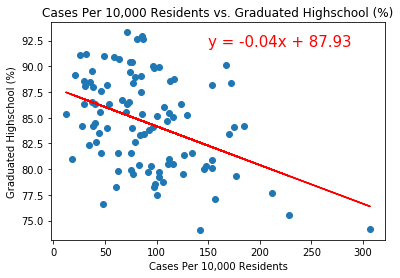

The r-squared is: 0.17062470838240795


In [22]:
regress_function('Cases Per 10,000 Residents','Graduated Highschool (%)',150,92,10)

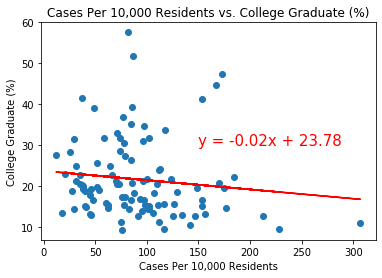

The r-squared is: 0.013877672388573506


In [23]:
regress_function('Cases Per 10,000 Residents','College Graduate (%)',150,30,11)

### NOTES:
#### A resonably high negative correlation for high school education and not much for college education.
#### Now we look at population density.

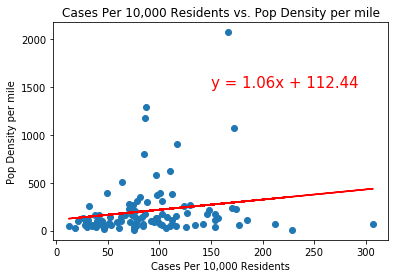

The r-squared is: 0.031213821133332414


In [24]:
regress_function('Cases Per 10,000 Residents','Pop Density per mile',150,1500,12)

# Multiple linear regression:

In [25]:
# -----------------------------------------------------------------------------------------------------------
# Now it's time to take a crack at multiple linear regression.
# No one demographic variable explains a particularly large amount of the variance in the proportional cases, 
# however together we should be able to explain a reasonable amount with a multiple linear regression.
# -----------------------------------------------------------------------------------------------------------

x = df[['Population', 'Population Under 18 (%)', 'White (%)', 'Median Household Income', 'Graduated Highschool (%)']]

X = sm.add_constant(x) # adding a constant

model = sm.OLS(df["Cases Per 10,000 Residents"], X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                                OLS Regression Results                                
Dep. Variable:     Cases Per 10,000 Residents   R-squared:                       0.419
Model:                                    OLS   Adj. R-squared:                  0.388
Method:                         Least Squares   F-statistic:                     13.54
Date:                        Thu, 23 Jul 2020   Prob (F-statistic):           6.01e-10
Time:                                12:22:02   Log-Likelihood:                -505.87
No. Observations:                         100   AIC:                             1024.
Df Residuals:                              94   BIC:                             1039.
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [26]:
x = df[['Pop Density per mile', 'Population 65 and Over (%)', 'White (%)', 'Median Household Income', 'Graduated Highschool (%)', '0 Risk Factor Pop (%)']]

X = sm.add_constant(x) # adding a constant

model = sm.OLS(df["Deaths/Population (%)"], X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     Deaths/Population (%)   R-squared:                       0.289
Model:                               OLS   Adj. R-squared:                  0.243
Method:                    Least Squares   F-statistic:                     6.291
Date:                   Thu, 23 Jul 2020   Prob (F-statistic):           1.41e-05
Time:                           12:22:02   Log-Likelihood:                 277.28
No. Observations:                    100   AIC:                            -540.6
Df Residuals:                         93   BIC:                            -522.3
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [27]:
df2 = df[['Population', 'Population Under 18 (%)', 'White (%)', 'Median Household Income', 'Graduated Highschool (%)']]
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
calc_vif(df2)

,variables,VIF
0,Population,2.144502
1,Population Under 18 (%),63.225089
2,White (%),26.212025
3,Median Household Income,56.871214
4,Graduated Highschool (%),141.637063


# Extra research:

In [28]:
# --------------------------------------------------------------------
# COVID testing location data
# From https://github.com/codersagainstcovidorg/covid19testing-backend
# --------------------------------------------------------------------

testing_df = pd.DataFrame(columns=['Name','Lat','Lon','City','State','Collecting','Evaluating'])
testing_df

base_url = "http://api.findcovidtesting.com/api/v1/location"
response = requests.get(base_url).json()

# -----------------------
# Use this to see how the response is structured:
#response[0]

# -----------------------
# Relevant info seems to be:
#     location_name
#     is_collecting_samples - boolean
#     is_evaluating_symptoms - boolean
#     location_address_locality = city
#     location_address_region = state
#     location_latitude
#     location_longitude

In [29]:
# Iterate through the response and store selected variables in dataframe

for i in range(len(response)):
    if response[i]['location_address_region'] == 'NC':
        testing_df.loc[i,'Name'] = response[i]['location_name']
        testing_df.loc[i,'Lat'] = response[i]['location_latitude']
        testing_df.loc[i,'Lon'] = response[i]['location_longitude']
        testing_df.loc[i,'City'] = response[i]['location_address_locality']
        testing_df.loc[i,'State'] = response[i]['location_address_region']
        testing_df.loc[i,'Collecting'] = response[i]['is_collecting_samples']
        testing_df.loc[i,'Evaluating'] = response[i]['is_evaluating_symptoms']

# Display the dataframe       
testing_df

,Name,Lat,Lon,City,State,Collecting,Evaluating
10,FastMed Urgent Care,35.3752,-77.9539,Goldsboro,NC,True,True
17,AFC Urgent Care Pineville,35.0936,-80.8581,,NC,True,True
47,Cape Fear Valley Hospital,35.0324,-78.9327,Fayetteville,NC,True,True
50,Fayetteville VA Coastal Health Care System,35.0879,-78.8768,Fayetteville,NC,True,True
62,Duke Raleigh Hospital,35.8287,-78.618,Raleigh,NC,True,True
...,...,...,...,...,...,...,...
9900,Avance Care - Northeast Raleigh,35.8767,-78.5384,Raleigh,NC,True,True
9949,New Hanover County Public Health COVID-19 Coll...,34.2433,-77.9497,Wilmington,NC,True,True
9968,Avance Care - North Raleigh,35.9054,-78.7026,Raleigh,NC,True,True
9986,Duke Urgent Care - Harps Mill,35.8821,-78.6265,Raleigh,NC,True,True


In [30]:
#---------------------------------------------
# Open csv of all NC counties and county seats
#---------------------------------------------

county_path = "data/nc_counties.csv"
county_df = pd.read_csv(county_path)

# Clean it up
county_df['nc_county'].replace(', North Carolina','',regex=True,inplace=True)

# Display the dataframe
county_df

,nc_county,county_seat
0,Alamance County,Graham
1,Alexander County,Taylorsville
2,Alleghany County,Sparta
3,Anson County,Wadesboro
4,Ashe County,Jefferson
...,...,...
95,Wayne County,Goldsboro
96,Wilkes County,Wilkesboro
97,Wilson County,Wilson
98,Yadkin County,Yadkinville


In [31]:
# Add latitude and longitude to the dataframe
county_df['Lat'] = ''
county_df['Lon'] = ''

print('--------------------')
print(f'Begin processing cities')
print('--------------------')

# Process city by city to get the latitude and longitude
for index, row in county_df.iterrows():
    target_city = f'{row[1]}, North Carolina'
    params = {"address": target_city, "key": google_api}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params=params)
    city_geo = response.json()
    
    row[2] = city_geo["results"][0]["geometry"]["location"]["lat"]
    row[3] = city_geo["results"][0]["geometry"]["location"]["lng"]
    
    print(f'Processing: {target_city}')

print('--------------------')
print(f'Processing complete')
print('--------------------')

# Display the dataframe
county_df

--------------------
Begin processing cities
--------------------
Processing: Graham, North Carolina
Processing: Taylorsville, North Carolina
Processing: Sparta, North Carolina
Processing: Wadesboro, North Carolina
Processing: Jefferson, North Carolina
Processing: Newland, North Carolina
Processing: Washington, North Carolina
Processing: Windsor, North Carolina
Processing: Elizabethtown, North Carolina
Processing: Bolivia, North Carolina
Processing: Asheville, North Carolina
Processing: Morganton, North Carolina
Processing: Concord, North Carolina
Processing: Lenoir, North Carolina
Processing: Camden, North Carolina
Processing: Beaufort, North Carolina
Processing: Yanceyville, North Carolina
Processing: Newton, North Carolina
Processing: Pittsboro, North Carolina
Processing: Murphy, North Carolina
Processing: Edenton, North Carolina
Processing: Hayesville, North Carolina
Processing: Shelby, North Carolina
Processing: Whiteville, North Carolina
Processing: New Bern, North Carolina
Proce

,nc_county,county_seat,Lat,Lon
0,Alamance County,Graham,36.069,-79.4006
1,Alexander County,Taylorsville,35.9217,-81.1769
2,Alleghany County,Sparta,36.5054,-81.1209
3,Anson County,Wadesboro,34.9682,-80.0767
4,Ashe County,Jefferson,36.4204,-81.4734
...,...,...,...,...
95,Wayne County,Goldsboro,35.3849,-77.9928
96,Wilkes County,Wilkesboro,36.146,-81.1606
97,Wilson County,Wilson,35.7213,-77.9155
98,Yadkin County,Yadkinville,36.1346,-80.6595


# Mapping

In [32]:
# -------------------------------
# Map facilities and counties out
# -------------------------------

# Set up gmaps
gmaps.configure(api_key=google_api)

# Build the map for testing locations
# Set center and zoom level
fig = gmaps.figure(map_type='HYBRID',center=(35.3,-79.5), zoom_level=7)

testing_locations = testing_df[['Lat', 'Lon']]
testing_info = testing_df['Name'].tolist()
testing_symbols = gmaps.symbol_layer(testing_locations, fill_color='white', stroke_color='white', scale = 2, info_box_content = testing_info)
fig.add_layer(testing_symbols)

# Build the map for county locations
seat_locations = county_df[['Lat', 'Lon']]
seat_info = county_df['nc_county'].tolist()
seat_symbols = gmaps.symbol_layer(seat_locations, fill_color='blue', stroke_color='blue', scale = 3, info_box_content = seat_info)
fig.add_layer(seat_symbols)

# Display the map
fig

Figure(layout=FigureLayout(height='420px'))